# Mobile Ad Anti-Fraud Algorithm Challenge - Modeling Part Ⅰ

## 移动广告反欺诈算法挑战赛 数据建模 Ⅰ
2019 科大讯飞 A.I.开发者挑战赛

-- Date:   25 Aug 2019  
-- Author:   Arianna.H

___

## 5.Modeling - randomforest, lightgbm

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  #display multiple outputs in one cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  #plot
import time

from sklearn.model_selection import train_test_split  #split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb  #lightgbm

In [2]:
df = pd.read_csv('round1_iflyad_anticheat_train_clean.csv')

In [3]:
df.shape
df.head(3)

(1000000, 46)

,label,pkgname,ver,adunitshowid,mediashowid,apptype,ip,city,province,reqrealip,...,hw_ratio,inch,osv_clean,osv_top1,osv_top2,osv_top3,ver_clean,ver_top1,ver_top2,ver_top3
0,1,402,174,452,239,280.0,475455,229,17,5102,...,2.2,859.1,138,8,81,810,74,1,11,111
1,1,2174,3180,45,61,319.0,41248,119,18,8127,...,0.5,0.0,140,9,9,9,0,0,0,0
2,0,230,626,422,282,273.0,563455,296,5,7875,...,2.0,0.0,138,8,81,810,1188,3,32,321


___

### Split train and validation set

In [4]:
traindata_x = df.drop(['label'],axis=1)
traindata_y = df['label']
x_train,x_test,y_train,y_test = train_test_split(traindata_x,traindata_y,train_size=.9,random_state=20,shuffle=True)

In [5]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(900000, 45) (900000,) (100000, 45) (100000,)


## 6.Tune RandomForest Model

Grid scores by RandomForest cv model:  

Best parameters set:  
{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50} with F1 score 0.9336814441944133

In [22]:
# Set the parameters by cross-validation

n_features = x_train.shape[1]

parameter_space = {
    "n_estimators": [20,50],  
    "min_samples_leaf": [2,4,6],
    'max_features':['sqrt','log2']  # try different numbers of features
}
 
scores = 'f1_macro'

# training    
print("# Tuning hyper-parameters for %s" % scores)
print()

clf = RandomForestClassifier(random_state=20, verbose=False)
grid = GridSearchCV(clf, parameter_space, cv=2, scoring='%s' % scores, n_jobs=4, verbose=False) 
grid.fit(x_train, y_train)

# print results
print("F1 scores on validation set:")
print()

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.6f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [14]:
print("Best parameters set:")
print('{} with F1 score {}'.format(grid.best_params_,grid.best_score_))

Best parameters set:
{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50} with F1 score 0.9336814441944133


### Fit GridSearch model with best parameters

In [21]:
# fit best estimator {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50} with F1 score 0.9336814441944133
bclf = grid.best_estimator_
bclf.fit(x_train, y_train)
y_true = y_test
y_pred = bclf.predict(x_test)
y_pred_pro = bclf.predict_proba(x_test)
y_scores = pd.DataFrame(y_pred_pro, columns=bclf.classes_.tolist())[1].values

### or... fit a RandomForestClassifier

In [105]:
# train RandomForestClassifier
tclf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=20, n_jobs=4, verbose=1)
md = tclf.fit(x_train, y_train)
y_pred_t = md.predict(x_test)

### Evaluation Metrics and performance on validation set

In [17]:
# precision, recall, f1 score
p = precision_score(y_true, y_pred, average='binary')
r = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')
 
print('precision_score: %s'% p)
print('recall_score: %s'% r)
print('f1_score: %s'% f1score)
print()
print(classification_report(y_true, y_pred))

precision_score: 0.9412916675440628
recall_score: 0.9231547643633059
f1_score: 0.932135000156395

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     51578
           1       0.94      0.92      0.93     48422

    accuracy                           0.93    100000
   macro avg       0.94      0.93      0.93    100000
weighted avg       0.94      0.93      0.93    100000



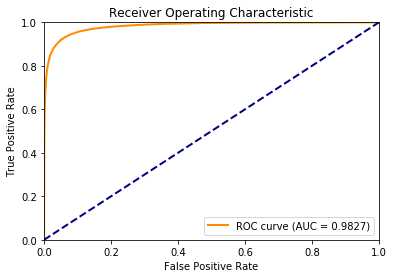

In [18]:
# plot ROC curve
auc_value = roc_auc_score(y_true, y_scores)
fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1.0)

_ = plt.figure()
lw = 2
_ = plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (AUC = %0.4f)' % auc_value)
_ = plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
_ = plt.xlim([0.0, 1.0])
_ = plt.ylim([0.0, 1.0])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Receiver Operating Characteristic')
_ = plt.legend(loc="lower right")
_ = plt.show()

In [19]:
# feature importance
features = df.columns[1:]
importances = bclf.feature_importances_
indices = np.argsort(importances)

feature_importance = pd.DataFrame()
feature_importance['features'] = features
feature_importance['importances'] = importances
feature_importance.sort_values(by='importances',ascending=False).head(10)
#feature_importance.sort_values(by='importances',ascending=False).features.head(10)

# for name, importance in zip(features, importances):
#     print(name, "=", importance)

,features,importances
35,hw_ratio,0.106628
15,make,0.064825
19,osv,0.060980
37,osv_clean,0.059115
38,osv_top1,0.046679
14,model,0.043960
13,dvctype,0.039135
3,mediashowid,0.036947
4,apptype,0.033940
41,ver_clean,0.027017


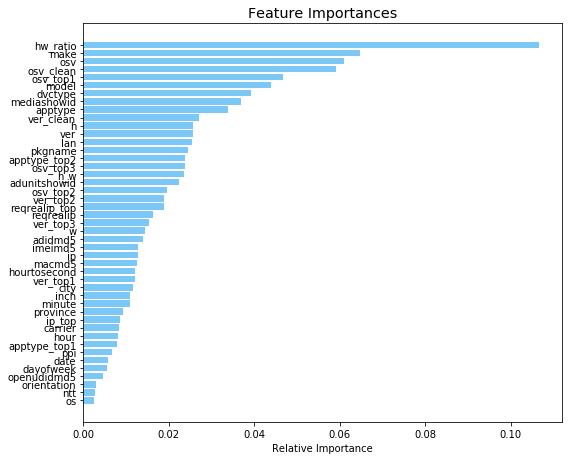

In [20]:
# plot feature importance
fig = plt.figure()
fig.set_size_inches(8,6.5)
_ = plt.title('Feature Importances', fontsize='x-large')
_ = plt.barh(range(len(indices)), importances[indices], color='xkcd:lightblue', align='center')
_ = plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize='medium')
_ = plt.xlabel('Relative Importance')
fig.tight_layout()
plt.show()

____

## 7.Tune Lightgbm Model

Grid scores by lightgbm:
 
1)   
Best parameters found by grid search are: {boosting_type='dart', 'learning_rate': 0.05, 'n_estimators': 3000, cv=3} => *('gbdt' is better in training speed and accuracy on test)*  
Best f1_macro score is: 0.9367622501566735  
elapsed: 87.6min finished  

2)  
Best parameters found by grid search are: {boosting_type='goss', 'learning_rate': 0.05, 'n_estimators': 3000, cv=2}  
Best f1_macro score is: 0.9367323275116014  
Time consuming: 11.88min  

3)
**=> BEST  
Best parameters found by grid search are: {'boosting_type': 'goss', 'learning_rate': 0.03, 'n_estimators': 5000, cv=2}  
Best f1_macro score is: 0.9369725573283804  
Time consuming: 29.25min  
f1_score on validation set: 0.934860**  

In [36]:
# Set the parameters by cross-validation

start=time.perf_counter()
params_opt = {
    'boosting_type':["goss"],
    'n_estimators': [3000,5000], 
    'learning_rate': [0.03,0.05]
}

model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    lambda_l2=0.2,
    num_leaves=31, 
    min_data_in_leaf=30,
    feature_fraction=0.5,  
#     bagging_fraction=0.8, 
#     bagging_freq=15,
    random_state=20
)

# training
print('Starting tuning hyper-parameters...')
gbm = GridSearchCV(estimator = model, 
    param_grid = params_opt, 
    scoring='f1_macro',
    n_jobs=5, 
    verbose=1,
    cv=2)
gbm.fit(x_train, y_train)
end=time.perf_counter()
print()
print('Time consuming: {:.2f}min'.format((end-start)/60))

Starting tuning hyper-parameters...
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed: 26.7min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed: 26.7min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.5,
                                      importance_type='split', lambda_l2=0.2,
                                      learning_rate=0.1, max_depth=-1,
                                      metric='binary_logloss',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data_in_leaf=30, min_split_gain=0.0,
                                      n_estimators=100, n...,
                                      num_leaves=31, objective='binary',
                                      random_state=20, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_f


Time consuming: 29.25min



In [37]:
# print out parameters
print("Grid scores on development set:")
print()
means = gbm.cv_results_['mean_test_score']
stds = gbm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gbm.cv_results_['params']):
    print("%0.6f (+/-%0.03f) for %r" % (mean, std * 2, params))     
print()
print('Best parameters found by grid search are: %s' % gbm.best_params_)
print('Best f1_macro score is: %s' % gbm.best_score_)

Grid scores on development set:

0.936435 (+/-0.000) for {'boosting_type': 'goss', 'learning_rate': 0.03, 'n_estimators': 3000}
0.936973 (+/-0.000) for {'boosting_type': 'goss', 'learning_rate': 0.03, 'n_estimators': 5000}
0.936732 (+/-0.000) for {'boosting_type': 'goss', 'learning_rate': 0.05, 'n_estimators': 3000}
0.936706 (+/-0.000) for {'boosting_type': 'goss', 'learning_rate': 0.05, 'n_estimators': 5000}

Best parameters found by grid search are: {'boosting_type': 'goss', 'learning_rate': 0.03, 'n_estimators': 5000}
Best f1_macro score is: 0.9369725573283804


### Fit model with best estimator

In [49]:
bgbm = gbm.best_estimator_
bgbm.fit(x_train, y_train)
y_pred = bgbm.predict(x_test)
y_pred_pro = bgbm.predict_proba(x_test)

### or.. fit a new LGBMClassifier

In [48]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

print('Starting training...')
# train
gbm = lgb.LGBMClassifier(boosting_type="gbdt",
                         objective='binary',
                         metric='binary_logloss',
                         learning_rate=0.05,
                         n_estimators=20,
                         reg_lambda=0.2,
                         num_leaves=31,
                         min_data_in_leaf=30,
                         feature_fraction=0.5,  
                         bagging_fraction=0.8, 
                         bagging_freq=15,
                         random_state=20,
                         silent=True)
gbm.fit(lgb_train, 
        eval_set=lgb_eval, 
        early_stopping_rounds=20)

print('Starting predicting...')
# predict
y_pred = gbm.predict_proba(x_test, num_iteration=gbm.best_iteration_)

# eval
print('The best Logloss on validation set is: ', gbm.evals_result_)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

### Evaluation metric

In [43]:
# precision, recall, f1 score
y_pred = bgbm.predict(x_test)
y_pred_pro = bgbm.predict_proba(x_test)
y_scores = pd.DataFrame(y_pred_pro, columns=bgbm.classes_.tolist())[1].values
p = precision_score(y_true, y_pred, average='binary')
r = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')
 
print('precision_score: %s'% p)
print('recall_score: %s'% r)
print('f1_score: %s'% f1score)
print()
print(classification_report(y_true, y_pred))

precision_score: 0.9430714916151809
recall_score: 0.926789475858081
f1_score: 0.9348595950337472

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     51578
           1       0.94      0.93      0.93     48422

    accuracy                           0.94    100000
   macro avg       0.94      0.94      0.94    100000
weighted avg       0.94      0.94      0.94    100000



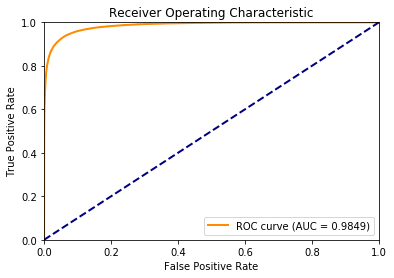

In [44]:
# plot ROC curve
auc_value = roc_auc_score(y_true, y_scores)
fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1.0)

_ = plt.figure()
lw = 2
_ = plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (AUC = %0.4f)' % auc_value)
_ = plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
_ = plt.xlim([0.0, 1.0])
_ = plt.ylim([0.0, 1.0])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Receiver Operating Characteristic')
_ = plt.legend(loc="lower right")
_ = plt.show()

In [46]:
# feature importance
features = df.columns[1:]
importances = bgbm.feature_importances_
indices = np.argsort(importances)

feature_importance = pd.DataFrame()
feature_importance['features'] = features
feature_importance['importances'] = importances
feature_importance.sort_values(by='importances',ascending=False).head(10)

,features,importances
14,model,11216
5,ip,7101
2,adunitshowid,6784
10,imeimd5,6678
6,city,6520
29,hourtosecond,6353
9,adidmd5,6176
34,h_w,5461
8,reqrealip,5073
22,h,4885


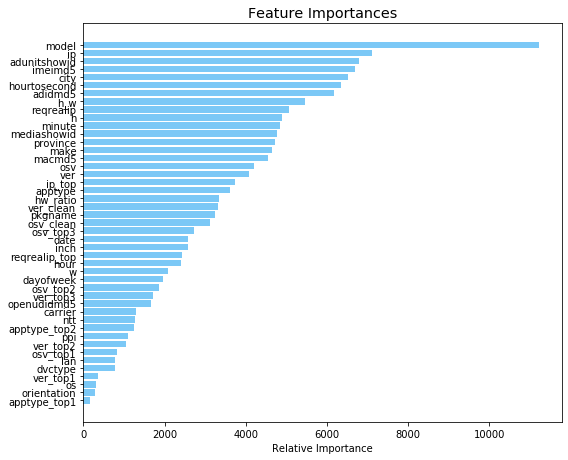

In [47]:
# plot feature importance
fig = plt.figure()
fig.set_size_inches(8,6.5)
_ = plt.title('Feature Importances', fontsize='x-large')
_ = plt.barh(range(len(indices)), importances[indices], color='xkcd:lightblue', align='center')
_ = plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize='medium')
_ = plt.xlabel('Relative Importance')
fig.tight_layout()
plt.show()

### Another version for training lightgbm with more details

In [104]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

#print('Best parameters found by grid search are:', gbm.best_params_)
# specify your configurations as a dict
params = {
'task': 'train',
'objective': 'binary',
'metric': 'binary_logloss',
'boosting': 'gbdt', 
'num_threads': 5,
'num_iterations': 3000,
'learning_rate': 0.07, 
'feature_fraction': 0.9,
'bagging_fraction': 0.8,
'bagging_freq': 50,
'min_data_in_leaf': 30, 
'random_seed':20,
'verbose':1
}


print('Start training...')

# train
gbm = lgb.train(params=gbm.best_params_, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=100)
print('Save model...')

# save model to file
gbm.save_model('lightgbm/model.txt')
print('Start predicting...')

# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

# eval
print(y_pred)
print('The roc of prediction is:', roc_auc_score(y_test, y_pred) )
print('Dump model to JSON...')

# dump model to json (and save to file)
model_json = gbm.dump_model()
with open('lightgbm/model.json', 'w+') as f:
    json.dump(model_json, f, indent=4)
    

# feature importances
gbm.feature_name()
gbm.feature_importance()

___

## 8.Compare best performance between models

RF: Best f1 score is : 0.933681  
LGB: Best f1_macro score is: 0.936973  

lgb > rf 